In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster')
sns.set_style('white')
%matplotlib inline

# Simulation Data

In systematically measuring genotype-phenotype data, how will the data be collected, stored and analyzed? Is a small laptop enough to model the fold change calculations locally? I explore this in the following notebook.

In [517]:
# Set n_genotypes > 1000 to obtain estimates of variance in error as a function of num_measurements
# Set n_genotypes < 15 to obtain diagnostic plots (traceplot) and comparison of modelled to actual.
# You've been forewarned - for the diagnostics and modelled, plotting with > 100 takes a while...
n_genotypes = 15

means = np.random.randint(low=10, high=100, size=n_genotypes)
means = means * (means > 0)  # negative activities are not captured
sds = np.random.random(size=n_genotypes) * 30
num_measurements = np.random.randint(low=2, high=5, size=n_genotypes)

# Create simulated data.
data = []
indices = []

for i in range(n_genotypes):
    n = num_measurements[i]
    mean = means[i]
    sd = sds[i]
    
    measurements = np.random.normal(loc=mean, scale=sd, size=n)
    # print(measurements)
    measurements = measurements * (measurements > 0)
    # print(measurements)
    
    data.extend(measurements.tolist())
    indices.extend([i] * n)

# Add baseline measurements (bl_measures)
n_bl_measures = 2
bl_measures = np.random.normal(loc=1.0, scale=0.1, size=n_bl_measures)
bl_measures = bl_measures * (bl_measures > 0)
data.extend(bl_measures)
indices.extend([n_genotypes] * n_bl_measures)
num_measurements = np.append(num_measurements, n_bl_measures)
means = np.append(means, bl_measures.mean())
sds = np.append(sds, bl_measures.std())

# Add pos_ctrl measurements (pc_measures)
n_pc_measures = 10
pc_measures = np.random.normal(loc=20.0, scale=2, size=n_pc_measures)
pc_measures = pc_measures * (pc_measures > 0)
data.extend(pc_measures)
indices.extend([n_genotypes + 1] * n_pc_measures)
num_measurements = np.append(num_measurements, n_pc_measures)
means = np.append(means, pc_measures.mean())
sds = np.append(sds, pc_measures.std())

# convert indices to a numpy array
indices = np.array(indices)

In [518]:
indices

array([ 0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  4,  4,  4,  5,  5,  5,  6,
        6,  6,  7,  7,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11,
       11, 11, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16])

In [519]:
means

array([ 18.        ,  73.        ,  53.        ,  36.        ,
        90.        ,  91.        ,  45.        ,  33.        ,
        33.        ,  62.        ,  33.        ,  54.        ,
        48.        ,  77.        ,  54.        ,   0.97175815,  19.90862571])

In [520]:
sds

array([  1.7400488 ,   3.02395656,  12.82650088,  16.94313358,
        27.62401836,  27.96461694,  15.99776144,  29.1658841 ,
        17.07223197,  28.92806679,  11.51035024,   8.47832567,
         2.8979268 ,  17.4331786 ,  15.53403219,   0.11719132,   1.23560237])

In [521]:
num_measurements

array([ 3,  3,  2,  2,  3,  3,  3,  2,  3,  4,  4,  4,  3,  4,  4,  2, 10])

In [522]:
len(data), len(indices)

(59, 59)

In [523]:
np.array(data)

array([  21.12932959,   18.49695405,   18.87361566,   72.32998714,
         71.79088369,   74.74563379,   49.88687052,   36.96561999,
         65.92926083,   52.51394185,   90.21184239,  136.92019275,
        135.39284715,  100.82619564,   91.44112457,   94.46391256,
         61.43670587,   55.66601684,   36.5661803 ,   67.59688069,
         47.6131857 ,   28.19638997,   23.41582428,   -0.        ,
         72.24412492,   27.79983081,   80.18695651,  101.96475561,
         29.55481113,   27.557771  ,   28.4100996 ,   50.10580108,
         59.31286549,   57.10447009,   48.57233231,   55.58820528,
         43.60443579,   49.36855256,   48.29831761,   60.39985787,
         70.36268252,   83.07537319,   67.93642109,   55.17237742,
         69.51337647,   63.67687314,   60.2604106 ,    0.85456683,
          1.08894946,   19.88480018,   19.42908401,   18.03711396,
         21.20622958,   20.31797404,   19.2360984 ,   18.12462726,
         22.0904228 ,   21.02927015,   19.73063669])

In [524]:
zp_det = 1 - (3 * sds[-2] + 3 * sds[-1]) / np.abs(means[-2] - means[-1])
zp_det

0.78568889315703072

In [569]:
with pm.Model() as model:
    # Hyperpriors
    # fold_mu = pm.Flat('fold_mu')
    # fold_sd = pm.HalfCauchy('fold_sd', 100)
    # fold_alpha = pm.Flat('fold_alpha')
    # fold_beta = pm.Flat('fold_beta')
    # fold_tau = pm.Exponential('fold_tau', lam=10)
    # fold_lam = pm.Beta('fold_lam', alpha=10, beta=1)

    # "Intercept", which is basically the measurement values.
    # fold = pm.Gamma('fold', alpha=1, beta=2, shape=n_genotypes+1)
    # fold = pm.HalfNormal('fold', tau=fold_tau, shape=n_genotypes+2)
    # fold = pm.Exponential('fold', lam=fold_lam, shape=n_genotypes+2)
    fold = pm.Uniform('fold', lower=1E-9, upper=1E9, shape=n_genotypes+2)
    
    # Assume that data have heteroskedastic (i.e. variable) error but are drawn from the same distribution
    sigma = pm.Gamma('sigma', alpha=1, beta=1, shape=n_genotypes+2)
    
    # Model prediction
    mu = fold[indices]
    sig = sigma[indices]
    
    # Data likelihood
    like = pm.Normal('like', mu=mu, sd=sig, observed=data)
    
    # Compute Z-factors relative to positive ctrl.
    z_factor = pm.Deterministic('z_factor', 1 - (3 * sigma[:-1] + 3 * sigma[-1]) / np.abs(fold[:-1] - fold[-1]))
    
    # Compute Z-prime factor between negative and positive control.
    zp_factor = pm.Deterministic('zp_factor', 1 - (3 * sigma[-2] + 3 * sigma[-1]) / np.abs(fold[-2] - fold[-1]))
    
    # Compute fold changes
    fold_changes = pm.Deterministic('fold_changes', fold[:-2] / fold[-1])

Applied interval-transform to fold and added transformed fold_interval_ to model.
Applied log-transform to sigma and added transformed sigma_log_ to model.


In [575]:
%%time
with model:
    if n_genotypes <= 10:
        n_steps = 150000
    elif n_genotypes > 10:
        n_steps = 200000
    params = pm.variational.advi(n=n_steps)
    trace = pm.variational.sample_vp(params, draws=2000)

Iteration 0 [0%]: ELBO = -1.9877984726753026e+19
Iteration 20000 [10%]: Average ELBO = -3.602100206711069e+18
Iteration 40000 [20%]: Average ELBO = -9901951783.89
Iteration 60000 [30%]: Average ELBO = -7128.18
Iteration 80000 [40%]: Average ELBO = -596.88
Iteration 100000 [50%]: Average ELBO = -576.58
Iteration 120000 [60%]: Average ELBO = -576.26
Iteration 140000 [70%]: Average ELBO = -576.21
Iteration 160000 [80%]: Average ELBO = -576.08
Iteration 180000 [90%]: Average ELBO = -576.26
Finished [100%]: Average ELBO = -576.15
CPU times: user 20.9 s, sys: 690 ms, total: 21.6 s
Wall time: 22 s


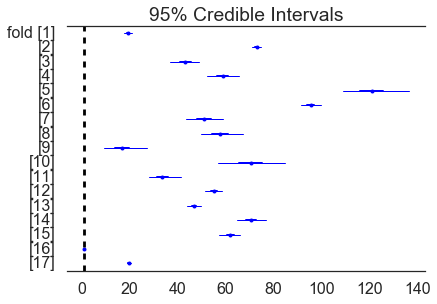

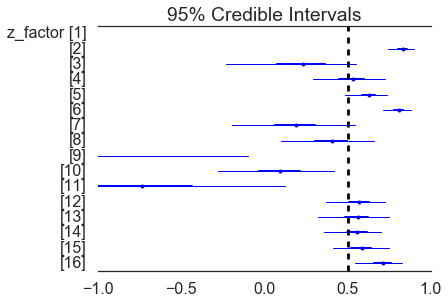

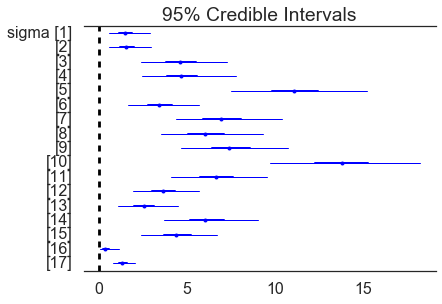

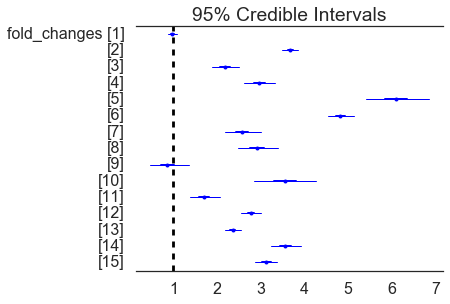

In [576]:
if n_genotypes <= 15:
    fig = plt.figure()
    pm.forestplot(trace, vline=1, varnames=['fold'])
    
    fig = plt.figure()
    pm.forestplot(trace, varnames=['z_factor'], xrange=(-1, 1), vline=0.5)
    
    fig = plt.figure()
    pm.forestplot(trace, varnames=['sigma'])
    
    plt.figure()
    pm.forestplot(trace, varnames=['fold_changes'], vline=1)

In [577]:
# plt.figure()
# pm.forestplot(trace, varnames=['fold_lam'])
# plt.figure()
# pm.traceplot(trace, varnames=['fold_lam'])

In [578]:
if n_genotypes <= 15:
    pm.summary(trace)


fold:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  19.415           0.849            0.021            [17.821, 21.124]
  72.959           0.907            0.020            [71.150, 74.679]
  43.370           3.250            0.075            [36.998, 49.161]
  58.951           3.468            0.075            [52.373, 65.517]
  121.144          6.986            0.154            [109.064, 136.439]
  95.564           2.076            0.049            [91.619, 99.603]
  51.164           4.087            0.094            [43.735, 59.100]
  57.811           4.566            0.092            [49.713, 67.107]
  17.415           4.712            0.098            [9.393, 27.087]
  70.802           7.340            0.154            [56.685, 84.926]
  33.953           3.459            0.070            [28.090, 41.420]
  55.134           1.892            0.046            [51.373, 58.546]
  46.836

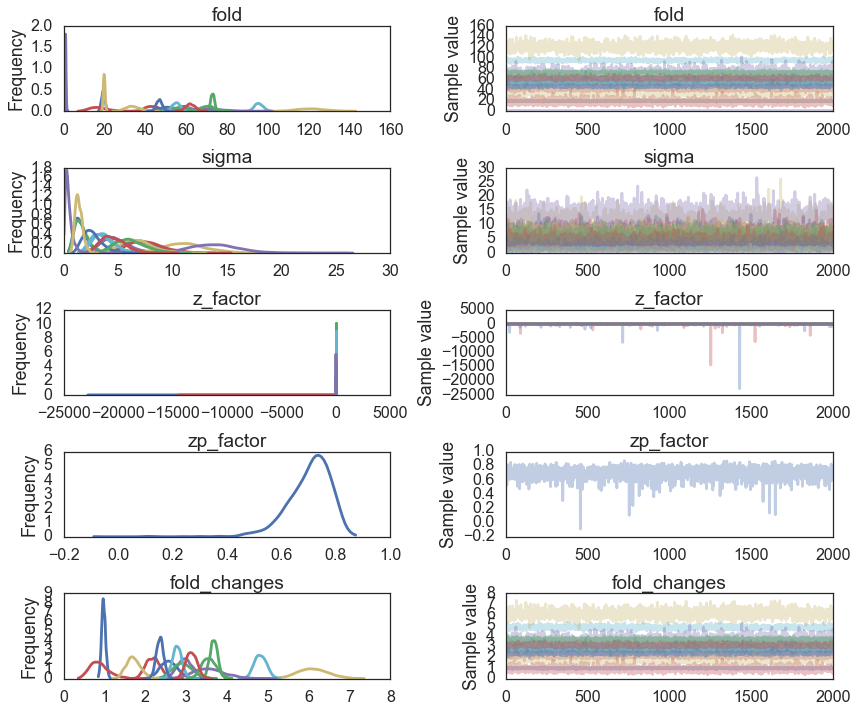

In [579]:
if n_genotypes <= 15:
    pm.traceplot(trace)

# Error in Estimated Mean

What is the error in estimated mean as a function of the number of measurements?

In [580]:
num_measurements

array([ 3,  3,  2,  2,  3,  3,  3,  2,  3,  4,  4,  4,  3,  4,  4,  2, 10])

In [581]:
trace['fold'].mean(axis=0) - means

array([  1.41520108e+00,  -4.08954700e-02,  -9.63028704e+00,
         2.29508132e+01,   3.11441035e+01,   4.56359348e+00,
         6.16351332e+00,   2.48109480e+01,  -1.55845503e+01,
         8.80201444e+00,   9.52834167e-01,   1.13379620e+00,
        -1.16445695e+00,  -6.31524980e+00,   8.08963757e+00,
         1.13707888e-02,  -5.98154993e-02])

In [582]:
import pandas as pd
errors_df = pd.DataFrame([num_measurements, (trace['fold'].mean(axis=0) - means)]).T
errors_df.columns = ['num_measurements', 'error_means']
errors_df.head()

,num_measurements,error_means
0,3.0,1.415201
1,3.0,-0.040895
2,2.0,-9.630287
3,2.0,22.950813
4,3.0,31.144103


In [583]:
if n_genotypes >= 500:
    sns.boxplot(data=errors_df, x='num_measurements', y='error_means')
    errors_df.groupby('num_measurements').var().plot(legend=False)
    plt.ylabel('var(error)')

In [584]:
(trace['fold'].mean(axis=0) - means).mean()

4.5436806274949717

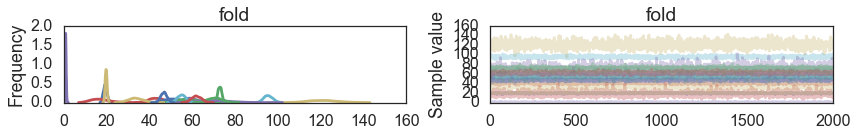

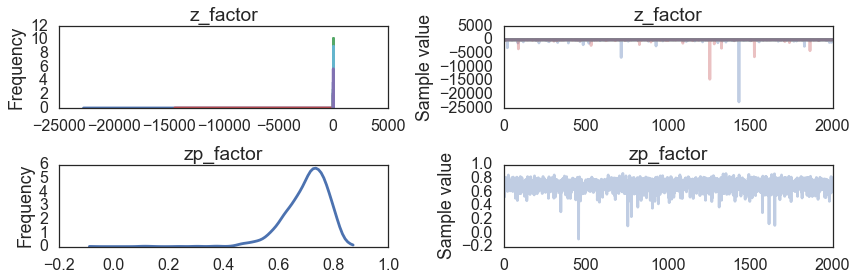

In [585]:
if n_genotypes <= 15:
    plt.figure()
    pm.traceplot(trace, varnames=['fold'])
    plt.figure()
    pm.traceplot(trace, varnames=['z_factor', 'zp_factor'])

# Compare modelled to actual

In [586]:
trace['fold'].mean(axis=0)

array([  19.41520108,   72.95910453,   43.36971296,   58.95081319,
        121.14410348,   95.56359348,   51.16351332,   57.81094805,
         17.41544967,   70.80201444,   33.95283417,   55.1337962 ,
         46.83554305,   70.6847502 ,   62.08963757,    0.98312893,
         19.84881021])

In [587]:
trace['fold'].mean(axis=0).shape

(17,)

In [588]:
np.arange(1, n_genotypes+3).shape

(17,)

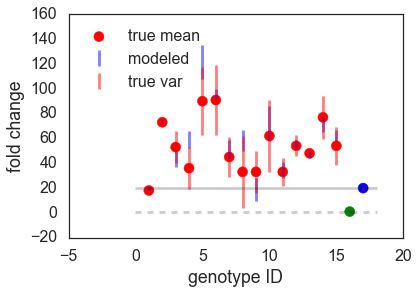

In [597]:
if n_genotypes <= 15:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lower = trace['fold'].mean(axis=0) - np.percentile(trace['fold'], 2.5, axis=0)
    upper = np.percentile(trace['fold'], 97.5, axis=0) - trace['fold'].mean(axis=0)
    yerr_pos = [lower, upper]
    ax.errorbar(x=np.arange(1, n_genotypes+3), y=trace['fold'].mean(axis=0), 
                # y-error bars
                yerr=yerr_pos,
                # styling
                color='blue', ls='none', alpha=0.5, label='modeled',)
    ax.scatter(x=np.arange(1, n_genotypes+3), y=means, 
               # styling
               color=['red'] * (n_genotypes) + ['green'] + ['blue'], marker='o', s=100, label='true mean',)
    ax.errorbar(x=np.arange(1, n_genotypes+3), y=means,
               yerr=sds,
               color='red', ls='none', alpha=0.5, label='true var')
    ax.legend(loc='upper left', frameon=False)
    ax.hlines(xmin=0, xmax=n_genotypes+3, y=trace['fold'].mean(axis=0)[-2], linestyles='--', alpha=0.2)
    ax.hlines(xmin=0, xmax=n_genotypes+3, y=trace['fold'].mean(axis=0)[-1], alpha=0.2)
    ax.set_xlabel('genotype ID')
    ax.set_ylabel('fold change')
    # ax.set_xlim(, n_genotypes+2)

just for checking the above plot...


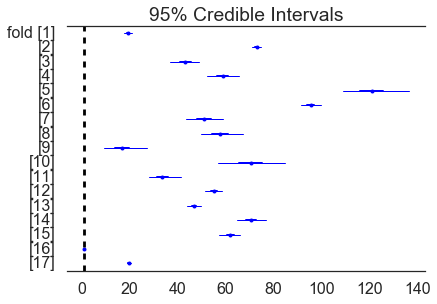

In [590]:
if n_genotypes <= 15:
    fig = plt.figure()
    pm.forestplot(trace, vline=1, varnames=['fold'])
print('just for checking the above plot...')

How does Z-factor vary as a function of variance for a fixed set of replicate measurements?

num_measurements
2    Axes(0.125,0.125;0.775x0.775)
3    Axes(0.125,0.125;0.775x0.775)
4    Axes(0.125,0.125;0.775x0.775)
dtype: object

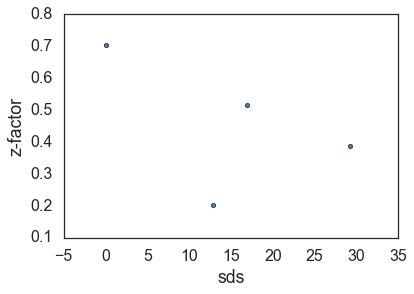

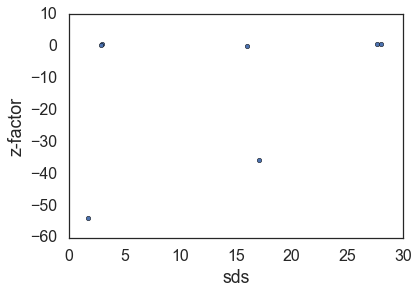

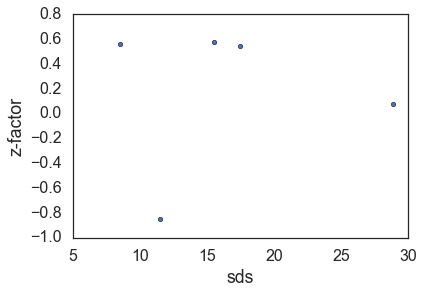

In [606]:
df = pd.DataFrame()
df['z-factor'] = trace['z_factor'].mean(axis=0)
df['num_measurements'] = num_measurements[:-1]
df['sds'] = sds[:-1]

df.groupby('num_measurements').plot(kind='scatter', x='sds', y='z-factor')

In [603]:
num_measurements.shape

(17,)

In [604]:
trace['z_factor'].shape

(2000, 16)